<a href="https://colab.research.google.com/github/jmperalta89/linkedinJMPERALTA/blob/main/De_analista_a_cient%C3%ADfico_de_datos_predicciones_b%C3%A1sicas_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  🐍 Predicciones básicas con Python  🐍

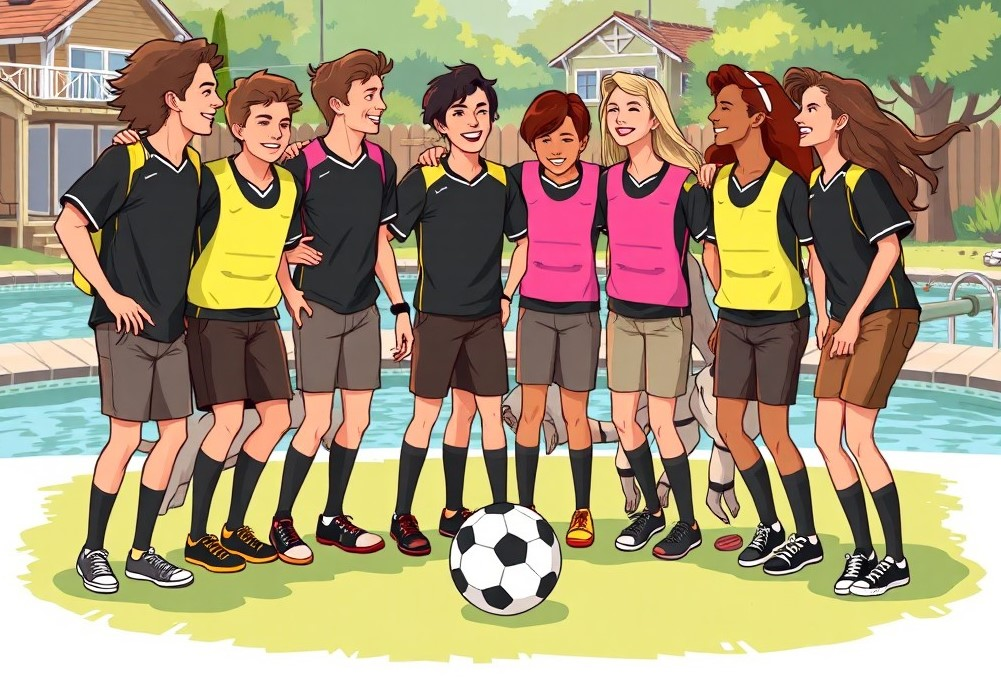

##Importo bibliotecas

In [ ]:
# Importo bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
import pandas as pd
# Conexión a Google
from oauth2client.service_account import ServiceAccountCredentials
# Bibliotecas para predicciones
from sklearn.metrics import accuracy_score, classification_report

##Conexión a google

In [ ]:
# Me conecto a google y levanto credenciales
from google.colab import files
# En este caso por cuestiones de seguridad, cargo mis credenciales desde un archivo json, no es seguro dejarlo cargado en la notebook
uploaded = files.upload()

Saving census-401510-1c6d3f606ded.json to census-401510-1c6d3f606ded.json


In [ ]:
# Configuración del acceso a Google Sheets
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("census-401510-1c6d3f606ded.json", scope)
client = gspread.authorize(creds)

In [ ]:
# Abrir la hoja de cálculo
spreadsheet = client.open("DDBB - Apioliga")

##Actualización de stats por partido

###Cargo dataset

In [ ]:
# Seleccionar las pestañas
goles_sheet = spreadsheet.worksheet("DDBB")
stats_sheet = spreadsheet.worksheet("STATS")

# Leer datos de Google Sheets en DataFrames
goles_df = pd.DataFrame(goles_sheet.get_all_records())
stats_df = pd.DataFrame(stats_sheet.get_all_records())

###Actualización de stats

In [ ]:
# Función para actualizar stats
def actualizar_stats(goles_df, stats_df):
    for partido in goles_df['Partido'].unique():
        partido_df = goles_df[goles_df['Partido'] == partido]
        equipo_ganador = partido_df[partido_df['Goles'] == partido_df['Goles'].max()]['Equipo'].iloc[0]

        # Actualizar stats para jugadores del equipo ganador
        for _, row in partido_df.iterrows():
            if row['Equipo'] == equipo_ganador:
                jugador = row['Jugador']
                if jugador in stats_df['NOMBRE'].values:
                    # Incrementar stats generales
                    stats_df.loc[stats_df['NOMBRE'] == jugador, ['RESISTENCIA', 'VELOCIDAD', 'DRIBLE', 'PEGADA', 'PASE', 'DEFENSA']] += 1
                    # Incrementar stats por goles
                    if row['Goles'] > 0:
                        stats_df.loc[stats_df['NOMBRE'] == jugador, ['RESISTENCIA', 'VELOCIDAD', 'DRIBLE', 'PEGADA', 'PASE', 'DEFENSA']] += 1

    # Actualizar la hoja de cálculo de stats
    stats_sheet.update([stats_df.columns.values.tolist()] + stats_df.values.tolist())

In [ ]:
# Ejecutar la actualización
actualizar_stats(goles_df, stats_df)

In [ ]:
# Definir los equipos
equipo_1 = ['La Torre', 'Profe', 'Galgo', 'Smith Sr', 'Norber']
equipo_2 = ['Smith Sra', 'Chiche', 'Pantera', 'Massi', 'Mbappe']

### Predicción de resultados 101 - En base a estadisticas

In [ ]:
def obtener_estadisticas_equipo(equipo, stats_df):
    # Filtrar las estadísticas de los jugadores del equipo
    equipo_df = stats_df[stats_df['NOMBRE'].isin(equipo)]
    # Sumar las estadísticas de todos los jugadores del equipo
    stats_equipo = equipo_df[['RESISTENCIA', 'VELOCIDAD', 'DRIBLE', 'PEGADA', 'PASE', 'DEFENSA']].sum()
    return stats_equipo

def predecir_resultado(equipo_1, equipo_2, stats_df):
    # Obtener las estadísticas de ambos equipos
    stats_equipo_1 = obtener_estadisticas_equipo(equipo_1, stats_df)
    stats_equipo_2 = obtener_estadisticas_equipo(equipo_2, stats_df)

    # Comparar las estadísticas (ejemplo simple: sumar todas las estadísticas y comparar)
    puntaje_equipo_1 = stats_equipo_1.sum()
    puntaje_equipo_2 = stats_equipo_2.sum()

    if puntaje_equipo_1 > puntaje_equipo_2:
        return 'Equipo 1 gana'
    elif puntaje_equipo_1 < puntaje_equipo_2:
        return 'Equipo 2 gana'
    else:
        return 'Empate'

In [ ]:
# Predicciones de ejemplo
predicciones = predecir_resultado(equipo_1, equipo_2, stats_df)

#Predecir resultados por stats

In [ ]:
# Evaluar precisión
def obtener_resultado_real(partido_df):
    # Agrupar por equipo y sumar los goles
    resultado = partido_df.groupby('Equipo')['Goles'].sum()
    equipo_ganador = resultado.idxmax() if resultado.nunique() > 1 else 'Empate'
    return equipo_ganador

def evaluar_precision(goles_df, stats_df):
    resultados_reales = []
    resultados_predichos = []

    for partido in goles_df['Partido'].unique():
        # Obtener datos del partido
        partido_df = goles_df[goles_df['Partido'] == partido]

        # Obtener los equipos del partido
        equipos = partido_df['Equipo'].unique()
        equipo_1 = list(partido_df[partido_df['Equipo'] == equipos[0]]['Jugador'])
        equipo_2 = list(partido_df[partido_df['Equipo'] == equipos[1]]['Jugador'])

        # Resultado real
        resultado_real = obtener_resultado_real(partido_df)
        resultados_reales.append(resultado_real)

        # Predicción
        prediccion = predecir_resultado(equipo_1, equipo_2, stats_df)
        prediccion = equipos[0] if prediccion == 'Equipo 1 gana' else equipos[1] if prediccion == 'Equipo 2 gana' else 'Empate'
        resultados_predichos.append(prediccion)

    # Calcular precisión
    precision = accuracy_score(resultados_reales, resultados_predichos)
    reporte = classification_report(resultados_reales, resultados_predichos)

    return precision, reporte


In [ ]:
# Evaluar la precisión
precision, reporte = evaluar_precision(goles_df, stats_df)
print(f"Precisión de las predicciones: {precision}")
print("Reporte de clasificación:")
print(reporte)

Precisión de las predicciones: 0.5833333333333334
Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.60      1.00      0.75         6
      Empate       0.00      0.00      0.00         4
           R       0.50      0.50      0.50         2

    accuracy                           0.58        12
   macro avg       0.37      0.50      0.42        12
weighted avg       0.38      0.58      0.46        12



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##Explicación del análisis:
Accuracy (Precisión general): 0.58
Esto es como decir que el adivino acierta el 58% de las veces. De cada 100 predicciones, acierta 58.

Recall (Exhaustividad):
De todas las veces que realmente llovió, ¿cuántas veces lo predijo correctamente el adivino? 1.00 para "A" significa que cada vez que ocurrió "A", el adivino lo predijo correctamente.

F1-score:
Es como una nota que combina precision y recall. Ayuda a entender qué tan bien lo está haciendo el adivino en general para cada tipo de clima.

Support:
Es simplemente cuántas veces ocurrió cada tipo de clima en realidad. Por ejemplo, "A" ocurrió 6 veces, "Empate" 4 veces, y "R" 2 veces.